In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from lob_data_utils import roc_results, gdf_pca
import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_dir = '../gdf_pca/res_lstm_reg_small'
filename_pattern = 'res_lstm_unit_{}_len10000_r{}_s{}.csv'
data_regular_dir = '../queue_imbalance/data/prepared/'
stocks = list(roc_results.results_10000.keys())
data_length = 10000
should_save_fig = False

In [3]:
mid_prices = []
df_huge = pd.DataFrame()
for stock in stocks:
    df_reg, df_reg_test = lob.load_prepared_data(
        stock, data_dir=data_regular_dir, cv=False, length=data_length)
    mid_prices.append({
        'stock': int(stock), 'mid_price': df_reg['mid_price'].mean(), 
        'spread': (df_reg['ask_price'] - df_reg['bid_price']).mean(),
        'mid_price_negative': len(df_reg[df_reg['mid_price_indicator'] == 0]),
        'mid_price_positive': len(df_reg[df_reg['mid_price_indicator'] == 1])
    })
    #df_huge = df_huge.append(df_reg)
df_regular = pd.DataFrame(mid_prices)
df_regular.head()

,mid_price,mid_price_negative,mid_price_positive,spread,stock
0,280.159303,3916,4084,0.107444,9069
1,439.943869,3986,4014,0.100712,9063
2,449.038569,3908,4092,0.289588,1472
3,1538.635500,3990,4010,1.015375,9094
4,2143.956719,3976,4024,0.650312,9270


In [4]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    parts_of_filename = f.split('_')
    stock = parts_of_filename[5]
    r = parts_of_filename[8][1:]
    s = parts_of_filename[9][1:].split('.csv')[0]
    df_stock = pd.read_csv(os.path.join(data_dir, f))
    df_stock['stock'] = [int(stock)] * len(df_stock)
    df_stock['r'] = [float(r)] * len(df_stock)
    df_stock['s'] = [float(s)] * len(df_stock)
    df_res = df_res.append(df_stock)
df_res.drop(columns=['Unnamed: 0'], inplace=True)
df_res.index = list(range(len(df_res)))
df_res.head()


,batch_size,epochs,f1,features,hidden_layer,kappa,kernel,matthews,pca_components,precision,...,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc,unit,r,s
0,10,5,0.560574,pca_n_gdf_que_prev,0,0.129196,lstm,0.130498,2,0.583383,...,0.562613,0.543000,0.120245,0.120745,0.558738,0.530046,0.559999,20,0.1,0.1
1,10,5,0.587693,pca_n_gdf_que_prev,1,0.132375,lstm,0.136009,2,0.579120,...,0.564071,0.567290,0.115778,0.118733,0.550169,0.594319,0.557689,20,0.1,0.1
2,10,5,0.465422,pca_n_gdf_que_prev,2,0.099409,lstm,0.101510,2,0.466043,...,0.563574,0.451554,0.093411,0.094799,0.442448,0.466278,0.546551,20,0.1,0.1
3,10,5,0.573731,pca_n_gdf_que_prev,0,0.124367,lstm,0.125640,2,0.561928,...,0.557010,0.570805,0.111160,0.111349,0.556275,0.586218,0.555553,20,0.1,0.1
4,10,5,0.572777,pca_n_gdf_que_prev,1,0.119508,lstm,0.124369,2,0.560955,...,0.548610,0.573631,0.111323,0.113328,0.556744,0.598574,0.555643,20,0.1,0.1


In [5]:
df_res.columns

Index(['batch_size', 'epochs', 'f1', 'features', 'hidden_layer', 'kappa',
       'kernel', 'matthews', 'pca_components', 'precision', 'recall',
       'regularization', 'roc_auc', 'stock', 'test_f1', 'test_kappa',
       'test_matthews', 'test_precision', 'test_recall', 'test_roc_auc',
       'train_f1', 'train_kappa', 'train_matthews', 'train_precision',
       'train_recall', 'train_roc_auc', 'train_val_f1', 'train_val_kappa',
       'train_val_matthews', 'train_val_precision', 'train_val_recall',
       'train_val_roc_auc', 'unit', 'r', 's'],
      dtype='object')

In [6]:
df_res = pd.merge(df_res, df_regular, on='stock')
df_res.columns

Index(['batch_size', 'epochs', 'f1', 'features', 'hidden_layer', 'kappa',
       'kernel', 'matthews', 'pca_components', 'precision', 'recall',
       'regularization', 'roc_auc', 'stock', 'test_f1', 'test_kappa',
       'test_matthews', 'test_precision', 'test_recall', 'test_roc_auc',
       'train_f1', 'train_kappa', 'train_matthews', 'train_precision',
       'train_recall', 'train_roc_auc', 'train_val_f1', 'train_val_kappa',
       'train_val_matthews', 'train_val_precision', 'train_val_recall',
       'train_val_roc_auc', 'unit', 'r', 's', 'mid_price',
       'mid_price_negative', 'mid_price_positive', 'spread'],
      dtype='object')

In [7]:
columns = ['stock', 'r', 's', 'features', 'matthews', 'roc_auc', 
           'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc', 'mid_price', 'spread', 'unit']
df_res[columns].sort_values(by='matthews', ascending=False).groupby(['stock', 'unit']).head(1)

,stock,r,s,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread,unit
81,1472,0.1,0.1,pca_n_gdf_que_prev,0.147314,0.572552,0.119977,0.556225,0.140004,0.569586,449.038569,0.289588,3
72,1472,0.1,0.1,pca_n_gdf_que_prev,0.143549,0.570500,0.116366,0.554192,0.139788,0.569516,449.038569,0.289588,1
5,9063,0.1,0.1,pca_n_gdf_que_prev,0.140542,0.569261,0.095327,0.547647,0.124353,0.562170,439.943869,0.100712,4
75,1472,0.1,0.1,pca_n_gdf_que_prev,0.139954,0.568774,0.115801,0.553354,0.139820,0.568997,449.038569,0.289588,20
78,1472,0.1,0.1,pca_n_gdf_que_prev,0.138642,0.568215,0.116121,0.553843,0.139099,0.568894,449.038569,0.289588,6
1,9063,0.1,0.1,pca_n_gdf_que_prev,0.136009,0.566190,0.082337,0.541158,0.128141,0.564071,439.943869,0.100712,20
8,9063,0.1,0.1,pca_n_gdf_que_prev,0.134778,0.566782,0.091481,0.545741,0.124628,0.562314,439.943869,0.100712,2
9,9063,0.1,0.1,pca_n_gdf_que_prev,0.130140,0.564623,0.087205,0.543559,0.126842,0.563404,439.943869,0.100712,1
84,10166,0.1,0.1,pca_n_gdf_que_prev,0.127680,0.563168,0.104090,0.552018,0.117284,0.558605,3115.380688,1.215750,3
12,9094,0.1,0.1,pca_n_gdf_que_prev,0.125640,0.562133,0.117635,0.558639,0.114164,0.557010,1538.635500,1.015375,20


In [8]:
df_res[columns].sort_values(by='matthews', ascending=False).groupby(['stock']).head(1)['unit'].value_counts()

4     3
20    2
3     2
8     1
Name: unit, dtype: int64

In [9]:
df_res[columns][df_res['s'] == 0.1].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

,stock,r,s,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread,unit
81,1472,0.1,0.1,pca_n_gdf_que_prev,0.147314,0.572552,0.119977,0.556225,0.140004,0.569586,449.038569,0.289588,3
5,9063,0.1,0.1,pca_n_gdf_que_prev,0.140542,0.569261,0.095327,0.547647,0.124353,0.562170,439.943869,0.100712,4
84,10166,0.1,0.1,pca_n_gdf_que_prev,0.127680,0.563168,0.104090,0.552018,0.117284,0.558605,3115.380688,1.215750,3
12,9094,0.1,0.1,pca_n_gdf_que_prev,0.125640,0.562133,0.117635,0.558639,0.114164,0.557010,1538.635500,1.015375,20
68,2651,0.1,0.1,pca_n_gdf_que_prev,0.115001,0.556437,0.160191,0.579520,0.122104,0.560642,488.642700,0.327325,8
45,9270,0.1,0.1,pca_n_gdf_que_prev,0.114984,0.556839,0.058879,0.529294,0.127241,0.563236,2143.956719,0.650312,20
59,9069,0.1,0.1,pca_n_gdf_que_prev,0.103022,0.549270,0.100281,0.550132,0.111152,0.555539,280.159303,0.107444,4
33,9061,0.1,0.1,pca_n_gdf_que_prev,0.099724,0.546379,0.078191,0.539036,0.086905,0.543443,685.278787,0.187775,4


In [10]:
df_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_best

,stock,r,s,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread,unit
81,1472,0.1,0.1,pca_n_gdf_que_prev,0.147314,0.572552,0.119977,0.556225,0.140004,0.569586,449.038569,0.289588,3
5,9063,0.1,0.1,pca_n_gdf_que_prev,0.140542,0.569261,0.095327,0.547647,0.124353,0.562170,439.943869,0.100712,4
84,10166,0.1,0.1,pca_n_gdf_que_prev,0.127680,0.563168,0.104090,0.552018,0.117284,0.558605,3115.380688,1.215750,3
12,9094,0.1,0.1,pca_n_gdf_que_prev,0.125640,0.562133,0.117635,0.558639,0.114164,0.557010,1538.635500,1.015375,20
68,2651,0.1,0.1,pca_n_gdf_que_prev,0.115001,0.556437,0.160191,0.579520,0.122104,0.560642,488.642700,0.327325,8
45,9270,0.1,0.1,pca_n_gdf_que_prev,0.114984,0.556839,0.058879,0.529294,0.127241,0.563236,2143.956719,0.650312,20
59,9069,0.1,0.1,pca_n_gdf_que_prev,0.103022,0.549270,0.100281,0.550132,0.111152,0.555539,280.159303,0.107444,4
33,9061,0.1,0.1,pca_n_gdf_que_prev,0.099724,0.546379,0.078191,0.539036,0.086905,0.543443,685.278787,0.187775,4


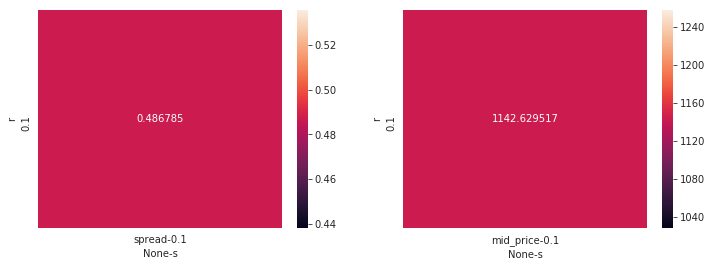

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
df_best1 = df_best[['r', 's', 'spread']]
sns.heatmap(df_best1.groupby(['r', 's']).mean().unstack(), annot=True, fmt='f', ax=ax1)
df_best1 = df_best[['r', 's', 'mid_price']]
sns.heatmap(df_best1.groupby(['r', 's']).mean().unstack(), annot=True, fmt='f', ax=ax2)

In [12]:
# mean 1338.327160 0.763437

df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['matthews'].mean()

nan

In [13]:
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

0.05723476095873048

In [14]:
df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

nan

In [15]:
df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

nan

In [16]:
df_best['r'].value_counts(), df_best['s'].value_counts()

(0.1    8
 Name: r, dtype: int64, 0.1    8
 Name: s, dtype: int64)

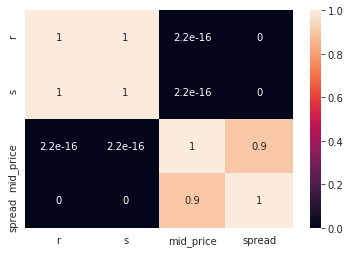

In [17]:
sns.heatmap(df_best[['r', 's', 'mid_price', 'spread']].corr(), annot=True)

,test_matthews,matthews,test_roc_auc,roc_auc
count,8.000000,8.000000,8.000000,8.000000
mean,0.104321,0.121739,0.551564,0.559505
std,0.030211,0.016836,0.014754,0.009097
min,0.058879,0.099724,0.529294,0.546379
25%,0.091043,0.111994,0.545495,0.554645
50%,0.102185,0.120321,0.551075,0.559486
75%,0.118220,0.130896,0.556828,0.564691
max,0.160191,0.147314,0.579520,0.572552


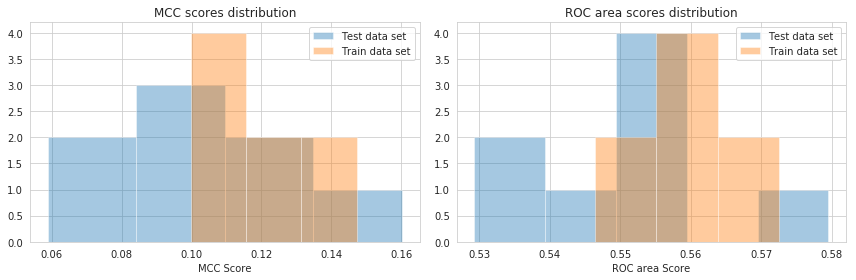

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_best['test_matthews'], kde=False, label='Test data set', ax=ax1)
sns.distplot(df_best['matthews'], kde=False, label='Train data set', ax=ax1)

ax1.legend()
ax1.set_xlabel('MCC Score')
ax1.set_title('MCC scores distribution')

sns.distplot(df_best['test_roc_auc'], kde=False, label='Test data set', ax=ax2)
sns.distplot(df_best['roc_auc'], kde=False, label='Train data set', ax=ax2)

ax2.legend()
ax2.set_xlabel('ROC area Score')
ax2.set_title('ROC area scores distribution')
plt.tight_layout()
plt.savefig('results_mlp_pca_score_dist.png')

df_best[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe()

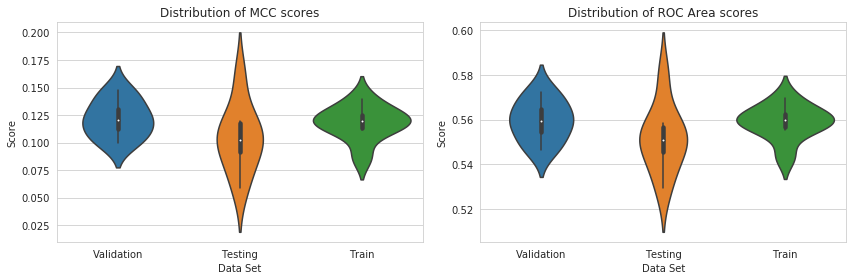

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df = df_best.copy()
df.rename(columns={'matthews': 'Validation', 'test_matthews': 'Testing', 'train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'r', 's',  'features', 'spread', 'mid_price', 
                   'roc_auc', 'test_roc_auc', 'train_roc_auc', 'unit'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best.copy()
df.rename(columns={'roc_auc': 'Validation', 'test_roc_auc': 'Testing', 'train_roc_auc': 'Train'}, inplace=True)
df = df.melt(['stock', 'r', 's', 'features', 'spread', 'mid_price', 
                   'matthews', 'test_matthews', 'train_matthews', 'unit'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')
plt.tight_layout()
plt.savefig('violin_distribution_scores_mlp.png')

In [20]:
print(df_best[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  test\_matthews &  matthews &  test\_roc\_auc &   roc\_auc \\
\midrule
count &       8.000000 &  8.000000 &      8.000000 &  8.000000 \\
mean  &       0.104321 &  0.121739 &      0.551564 &  0.559505 \\
std   &       0.030211 &  0.016836 &      0.014754 &  0.009097 \\
min   &       0.058879 &  0.099724 &      0.529294 &  0.546379 \\
25\%   &       0.091043 &  0.111994 &      0.545495 &  0.554645 \\
50\%   &       0.102185 &  0.120321 &      0.551075 &  0.559486 \\
75\%   &       0.118220 &  0.130896 &      0.556828 &  0.564691 \\
max   &       0.160191 &  0.147314 &      0.579520 &  0.572552 \\
\bottomrule
\end{tabular}



In [21]:
df_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

df_log = pd.read_csv('../gdf_pca/res_log_que.csv')
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['', '_log'])

In [22]:
df = df_best.copy()
columns = ['stock', 'r', 's', 'alpha', 'features', 'matthews_mlp', 'roc_auc_mlp',
       'test_matthews_mlp', 'test_roc_auc_mlp', 'train_matthews_mlp',
       'train_roc_auc_mlp', 'mid_price', 'spread', 'Unnamed: 0', 'f1', 'kappa',
       'matthews_log', 'precision', 'recall', 'roc_auc_log', 'test_f1_score',
       'test_kappa', 'test_matthews_log', 'test_precision', 'test_recall',
       'test_roc_auc_log', 'train_f1', 'train_kappa', 'train_matthews_log',
       'train_precision', 'train_recall', 'train_roc_auc_log']

df['test_matthews_diff'] = df['test_matthews'] - df['test_matthews_log']
df['train_matthews_diff'] = df['train_matthews'] - df['train_matthews_log']
df['validation_matthews_diff'] = df['matthews'] - df['matthews_log']
df['test_roc_auc_diff'] = df['test_roc_auc'] - df['test_roc_auc_log']
df['train_roc_auc_diff'] = df['train_roc_auc'] - df['train_roc_auc_log']
df['validation_roc_auc_diff'] = df['roc_auc'] - df['roc_auc_log']

print(df[['test_matthews_diff', 'train_matthews_diff', 'validation_matthews_diff',
   'test_roc_auc_diff', 'train_roc_auc_diff', 'validation_roc_auc_diff']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  test\_matthews\_diff &  train\_matthews\_diff &  validation\_matthews\_diff &  test\_roc\_auc\_diff &  train\_roc\_auc\_diff &  validation\_roc\_auc\_diff \\
\midrule
count &            8.000000 &             8.000000 &                  8.000000 &           8.000000 &            8.000000 &                 8.000000 \\
mean  &           -0.000545 &             0.000304 &                  0.002263 &          -0.000285 &            0.000043 &                 0.000962 \\
std   &            0.014062 &             0.003809 &                  0.009598 &           0.006883 &            0.001889 &                 0.005117 \\
min   &           -0.019804 &            -0.004669 &                 -0.018249 &          -0.010032 &           -0.002340 &                -0.010276 \\
25\%   &           -0.011569 &            -0.001952 &                  0.001348 &          -0.005379 &           -0.001116 &                 0.000326 \\
50\%   &            0.002316 &  

In [23]:
df[['test_matthews_diff', 'train_matthews_diff', 'validation_matthews_diff',
   'test_roc_auc_diff', 'train_roc_auc_diff', 'validation_roc_auc_diff']].describe()

,test_matthews_diff,train_matthews_diff,validation_matthews_diff,test_roc_auc_diff,train_roc_auc_diff,validation_roc_auc_diff
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.000545,0.000304,0.002263,-0.000285,0.000043,0.000962
std,0.014062,0.003809,0.009598,0.006883,0.001889,0.005117
min,-0.019804,-0.004669,-0.018249,-0.010032,-0.002340,-0.010276
25%,-0.011569,-0.001952,0.001348,-0.005379,-0.001116,0.000326
50%,0.002316,0.000383,0.003356,0.000567,0.000225,0.001940
75%,0.009891,0.001580,0.005830,0.004947,0.000630,0.003052
max,0.017670,0.007133,0.014904,0.008906,0.003231,0.007372


In [24]:
print(df[df['test_matthews_diff'] > 0]['stock'].count(), df[df['test_roc_auc_diff'] > 0]['stock'].count())
print(df[df['train_matthews_diff'] > 0]['stock'].count(), df[df['train_roc_auc_diff'] > 0]['stock'].count())
print(df[df['validation_matthews_diff'] > 0]['stock'].count(), df[df['validation_roc_auc_diff'] > 0]['stock'].count())
len(df['stock'].unique())

4 4
5 5
6 6


8

In [25]:
df[df['test_matthews_diff'] > 0]['stock'].count(), df[df['test_roc_auc_diff'] > 0]['stock'].count()

(4, 4)

## Results by r s using the alg

In [26]:
df_best_alg = pd.DataFrame()
df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [0 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))
    
    
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [1 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01] # 0.01 #TODO: it is currently the same...
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest['cat'] = [2 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest['cat'] = [3 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

c = ['stock', 'r', 's', 'cat', 'matthews', 'matthews_log', 
           'test_matthews', 'test_matthews_log', 'train_matthews', 'mid_price', 'spread']

df_best_alg = pd.merge(df_best_alg, df_log, on='stock', suffixes=['', '_log'])
print(len(df_best_alg[df_best_alg['test_matthews'] > df_best_alg['test_matthews_log']]))
df_best_alg[c].head()

0


,stock,r,s,cat,matthews,matthews_log,test_matthews,test_matthews_log,train_matthews,mid_price,spread
0,9270,0.1,0.1,1.0,0.114984,0.10008,0.058879,0.068277,0.127241,2143.956719,0.650312


In [27]:
df_best_alg = pd.DataFrame()
df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [0 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))
    
    
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [1 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01] # 0.01 #TODO: it is currently the same...
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [2 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [3 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

c = ['stock', 'r', 's', 'cat', 'matthews', 'matthews_log', 
           'test_matthews', 'test_matthews_log', 'train_matthews', 'mid_price', 'spread']

df_best_alg = pd.merge(df_best_alg, df_log, on='stock', suffixes=['', '_log'])
print(len(df_best_alg[df_best_alg['test_matthews'] > df_best_alg['test_matthews_log']]))
df_best_alg[c].head()

1


,stock,r,s,cat,matthews,matthews_log,test_matthews,test_matthews_log,train_matthews,mid_price,spread
0,9270,0.1,0.1,1.0,0.114984,0.100080,0.058879,0.068277,0.127241,2143.956719,0.650312
1,10166,0.1,0.1,3.0,0.127680,0.128722,0.104090,0.092939,0.117284,3115.380688,1.215750
2,9094,0.1,0.1,3.0,0.125640,0.123496,0.117635,0.137438,0.114164,1538.635500,1.015375


In [28]:
c = ['stock', 'r', 's', 'train_matthews', 'matthews', 'matthews_log', 
           'test_matthews', 'test_matthews_log',  'mid_price', 'spread']
df_best[df_best['matthews'] > df_best['train_matthews'] + 0.02][c]

,stock,r,s,train_matthews,matthews,matthews_log,test_matthews,test_matthews_log,mid_price,spread
